In [ ]:
import torch
print(torch.__version__)


2.8.0+cu126


In [ ]:
import torch
print(torch.__version__)


2.8.0+cu126


In [ ]:
# =================== SETUP ===================

!pip install torch torchvision --quiet
from google.colab import drive
drive.mount('/content/drive')

import os
SAVE_PATH = "/content/drive/MyDrive/fedavg/"
os.makedirs(SAVE_PATH, exist_ok=True)

import copy
import math
import random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms


Mounted at /content/drive


In [ ]:
# ================= CIFAR-10 LOAD (32x32, IID) =================

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])

# Define the path to the dataset in Google Drive
DATA_PATH = "/content/drive/MyDrive/data/cifar-10/"

trainset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True,
                                        download=True, transform=transform) # Set download to False
testset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False,
                                       download=True, transform=transform) # Set download to False

test_loader = DataLoader(testset, batch_size=128, shuffle=False)

num_clients = 5
data_per_client = len(trainset) // num_clients
client_indices = [list(range(i*data_per_client, (i+1)*data_per_client)) for i in range(num_clients)]
client_loaders = [
    DataLoader(Subset(trainset, idxs), batch_size=64, shuffle=True)
    for idxs in client_indices
]

In [ ]:
# ================= SMALL RESNET-18 =================

from torchvision.models import resnet18

def small_resnet18(num_classes=10, width_scale=0.5):
    model = resnet18(num_classes=num_classes)
    # scale width of all conv layers
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            out_channels = int(module.out_channels * width_scale)
            module.out_channels = out_channels
    return model

from torchvision.models import resnet18

def init_model():
    model = resnet18(num_classes=10).to('cuda')
    return model



In [ ]:
class Client:
    def __init__(self, dataloader):
        self.dataloader = dataloader

    def train_local(self, global_model, local_epochs):
        model = copy.deepcopy(global_model).to('cuda')
        model.train()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        criterion = nn.CrossEntropyLoss()

        for _ in range(local_epochs):
            for x, y in self.dataloader:
                x, y = x.cuda(), y.cuda()
                optimizer.zero_grad()
                loss = criterion(model(x), y)
                loss.backward()
                optimizer.step()
        return model


In [ ]:
# ================= SERVER (AGGREGATION) =================

def aggregate(global_model, client_models):
    new_model = copy.deepcopy(global_model)
    state_dicts = [m.state_dict() for m in client_models]

    avg_state = copy.deepcopy(state_dicts[0])
    for k in avg_state.keys():
        for i in range(1, len(state_dicts)):
            avg_state[k] += state_dicts[i][k]
        avg_state[k] = avg_state[k] / len(state_dicts)

    new_model.load_state_dict(avg_state)
    return new_model


In [ ]:
from torch.nn.utils import parameters_to_vector, vector_to_parameters

def get_update_vector(global_model, client_model):
    g = parameters_to_vector(client_model.parameters()) - parameters_to_vector(global_model.parameters())
    return g.detach().clone()

def apply_update_vector(global_model, update_vec):
    new_model = copy.deepcopy(global_model)
    vector_to_parameters(parameters_to_vector(global_model.parameters()) + update_vec, new_model.parameters())
    return new_model

def harmonize_updates(update_list):
    M = len(update_list)
    updates = [u.clone() for u in update_list]

    for i in range(M):
        for j in range(i+1, M):
            gi = updates[i].clone()
            gj = updates[j].clone()

            dot = torch.dot(gi, gj)
            if dot < 0:  # conflict detected
                gi_norm = torch.norm(gi).pow(2) + 1e-12
                gj_norm = torch.norm(gj).pow(2) + 1e-12

                # Compute projections using *original* gi, gj
                proj_i_on_j = (dot / gj_norm) * gj
                proj_j_on_i = (dot / gi_norm) * gi

                # Update *both* vectors symmetrically
                updates[i] = gi - proj_i_on_j
                updates[j] = gj - proj_j_on_i

    return updates

def aggregate_gh(global_model, client_models):
    # Step 1: compute flat updates
    updates = [get_update_vector(global_model, cm) for cm in client_models]

    # Step 2: harmonize
    updates_h = harmonize_updates(updates)

    # Step 3: average harmonized update
    avg_update = sum(updates_h) / len(updates_h)

    # Step 4: apply update to global model
    new_global = apply_update_vector(global_model, avg_update)

    # Step 5: ALSO aggregate BatchNorm buffers (critical)
    with torch.no_grad():
        state_dicts = [cm.state_dict() for cm in client_models]
        new_sd = new_global.state_dict()

        for key in new_sd.keys():
            # Only update BN buffers, not trainable params
            if "running_mean" in key or "running_var" in key:
                buf = sum(sd[key] for sd in state_dicts) / len(state_dicts)
                new_sd[key].copy_(buf)

        new_global.load_state_dict(new_sd)

    return new_global



In [ ]:
from torchvision.models import resnet18

def init_model():
    model = resnet18(num_classes=10)
    model = model.to('cuda')
    return model


In [ ]:
clients = [Client(loader) for loader in client_loaders]

def run_experiment(K):
    global_model = init_model()
    running_min = 1e9

    epochs_total = 20
    rounds = epochs_total // K

    print(f"\n===== K = {K} | {rounds} Aggregation Rounds =====")

    accs, drifts, regrets = [], [], []

    for r in range(1, rounds+1):
        client_models = [c.train_local(global_model, K) for c in clients]
        global_model = aggregate_gh(global_model, client_models)





        print(f"Round {r:02d} | Acc: {acc:.2f}% | Drift: {drift:.3f} | Regret: {regret:.4f}")

        if r % 5 == 0 or r == rounds:
            torch.save(global_model.state_dict(),
                       SAVE_PATH + f"fedavg_K{K}_round{r}.pt")

    return accs, drifts, regrets


In [ ]:
# ================= GLOBAL EVALUATION =================

def evaluate(model, loader=test_loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.cuda(), y.cuda()
            logits = model(x)
            loss_sum += criterion(logits, y).item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return (correct / total) * 100, loss_sum / total


# ================= DRIFT MEASUREMENT =================

def weight_distance(m1, m2):
    s1, s2 = m1.state_dict(), m2.state_dict()
    total = 0.0
    for k in s1.keys():
        if not s1[k].dtype.is_floating_point:
            continue
        total += torch.norm((s1[k] - s2[k]).float()).item()
    return total

def compute_drift(global_model, client_models):
    return sum(weight_distance(client_models[i], global_model)
               for i in range(len(client_models))) / len(client_models)


In [ ]:
def run_experiment(K, clients, use_fedgh=True, tag=""):
    global_model = init_model()
    running_min = 1e9

    total_epochs = 20
    rounds = total_epochs // K

    accs, drifts, regrets = [], [], []

    print(f"\n==== RUN ({tag}) | K={K} | ROUNDS={rounds} ====")

    for r in range(1, rounds+1):
        client_models = [c.train_local(global_model, K) for c in clients]

        drift = compute_drift(global_model, client_models)

        if use_fedgh:
            global_model = aggregate_gh(global_model, client_models)
        else:
            global_model = aggregate(global_model, client_models)

        acc, loss = evaluate(global_model, test_loader)
        running_min = min(running_min, loss)
        regret = loss - running_min

        accs.append(acc)
        drifts.append(drift)
        regrets.append(regret)

        print(f"Round {r:02d} | Acc={acc:.2f}% | Drift={drift:.4f} | Regret={regret:.4f}")

        # SAVE EVERY 5 EPOCHS (K epochs per round)
        epochs_elapsed = r * K
        if epochs_elapsed % 5 == 0 or r == rounds:
            torch.save(global_model.state_dict(),
                       SAVE_PATH + f"{tag}_epoch{epochs_elapsed}.pt")
            print(f"Saved checkpoint at {epochs_elapsed} epochs → {SAVE_PATH}{tag}_epoch{epochs_elapsed}.pt")

    return accs, drifts, regrets


In [ ]:
def make_dirichlet_clients(alpha, num_clients):
    labels = np.array(trainset.targets)
    idxs_by_class = {c: np.where(labels == c)[0] for c in range(10)}

    client_indices = [[] for _ in range(num_clients)]

    for c in range(10):
        class_indices = np.random.permutation(idxs_by_class[c])
        # sample distribution
        proportions = np.random.dirichlet([alpha] * num_clients)

        # ensure we don't create 0 for all except one
        proportions = np.maximum(proportions, 1e-6)
        proportions = proportions / proportions.sum()

        split_sizes = (proportions * len(class_indices)).astype(int)

        # ensure total matches
        diff = len(class_indices) - np.sum(split_sizes)
        for i in range(diff):
            split_sizes[i % num_clients] += 1

        # now split
        splits = np.split(class_indices, np.cumsum(split_sizes)[:-1])

        for i in range(num_clients):
            client_indices[i].extend(splits[i])

    # Remove clients with zero samples (rare but happens when α extremely small)
    client_indices = [idxs if len(idxs) > 0 else [0] for idxs in client_indices]

    loaders = [
        DataLoader(Subset(trainset, idxs), batch_size=64, shuffle=True)
        for idxs in client_indices
    ]
    return [ClientSAM(loader, rho=0.05) for loader in loaders]


In [ ]:
class ClientSAM:
    def __init__(self, dataloader, rho=0.05):
        self.dataloader = dataloader
        self.rho = rho

    def train_local(self, global_model, local_epochs):
        model = copy.deepcopy(global_model).to('cuda')
        model.train()

        # Freeze BatchNorm RUNNING STATS but allow affine parameters
        # Freeze BatchNorm statistics (critical for non-IID stability)
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()              # do not update running_mean / running_var
                m.requires_grad_(True) # still train affine gamma/beta parameters


        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        criterion = nn.CrossEntropyLoss()

        for _ in range(local_epochs):
            for x, y in self.dataloader:
                x, y = x.cuda(), y.cuda()

                # --- 1) ASCENT STEP ---
                optimizer.zero_grad()
                logits = model(x)
                loss = criterion(logits, y)
                loss.backward()

                # Compute gradient norm
                grad_vec = []
                for p in model.parameters():
                    if p.grad is not None:
                        grad_vec.append(p.grad.view(-1))
                grad_vec = torch.cat(grad_vec)
                grad_norm = torch.norm(grad_vec) + 1e-12

                # Apply perturbation δ = rho * g / ||g||
                for p in model.parameters():
                    if p.grad is not None:
                        p.data.add_(p.grad * (self.rho / grad_norm))

                # --- 2) DESCENT STEP ---
                optimizer.zero_grad()
                logits_adv = model(x)
                loss_adv = criterion(logits_adv, y)
                loss_adv.backward()
                optimizer.step()

                # Remove perturbation: SAM original requires restoring weights,
                # but this two-pass version handles it implicitly.

        return model


In [ ]:
from pathlib import Path
SAVE_PATH = Path("/content/drive/MyDrive/fedavg")
SAVE_PATH.mkdir(parents=True, exist_ok=True)


In [ ]:
def run_fedsam_experiment(K, clients, rho, tag):
    global_model = init_model()
    rounds = 20 // K

    accs, drifts = [], []
    print(f"\n===== FedSAM | rho={rho} | K={K} | {rounds} Rounds =====")

    for r in range(1, rounds + 1):
        # Local training
        client_models = [c.train_local(global_model, K) for c in clients]

        # Standard FedAvg aggregation (FedSAM does NOT change aggregation)
        global_model = aggregate(global_model, client_models)

        # Evaluate + Drift
        acc, _ = evaluate(global_model)
        drift = compute_drift(global_model, client_models)

        accs.append(acc)
        drifts.append(drift)

        print(f"Round {r:02d} | Acc: {acc:.2f}% | Drift: {drift:.3f}")

        if r % 5 == 0 or r == rounds:
           torch.save(global_model.state_dict(),
               SAVE_PATH / f"{tag}_rho{rho}_round{r}.pt")

    return accs, drifts


In [ ]:
rhos = [0.01, 0.05, 0.75]
K = 5

fedsam_results = {}

for rho in rhos:
    clients_sam = [ClientSAM(loader, rho=rho) for loader in client_loaders]
    accs, drifts = run_fedsam_experiment(K, clients_sam, rho, tag="FedSAM_IID")
    fedsam_results[rho] = (accs, drifts)



===== FedSAM | rho=0.01 | K=5 | 4 Rounds =====
Round 01 | Acc: 41.24% | Drift: 29.181
Round 02 | Acc: 60.97% | Drift: 29.973
Round 03 | Acc: 65.65% | Drift: 35.895
Round 04 | Acc: 68.32% | Drift: 39.113

===== FedSAM | rho=0.05 | K=5 | 4 Rounds =====
Round 01 | Acc: 10.00% | Drift: 6.922
Round 02 | Acc: 10.00% | Drift: 1.446
Round 03 | Acc: 10.00% | Drift: 0.650
Round 04 | Acc: 10.00% | Drift: 0.413

===== FedSAM | rho=0.1 | K=5 | 4 Rounds =====
Round 01 | Acc: 10.00% | Drift: 13.874
Round 02 | Acc: 10.00% | Drift: 0.776
Round 03 | Acc: 10.00% | Drift: 0.256
Round 04 | Acc: 10.00% | Drift: 0.112

===== FedSAM | rho=0.2 | K=5 | 4 Rounds =====
Round 01 | Acc: 10.00% | Drift: 30.729
Round 02 | Acc: 10.00% | Drift: 0.221
Round 03 | Acc: 10.00% | Drift: 0.240
Round 04 | Acc: 10.00% | Drift: 0.234


In [ ]:
alphas = [0.001, 0.01, 0.1, 1.0]
rho_best = 0.01  # Later we'll confirm from ablation curves
dirichlet_results = {}

for alpha in alphas:
    print(f"\n===== Dirichlet α={alpha} | FedSAM rho={rho_best} =====")
    clients_sam = make_dirichlet_clients(alpha, num_clients)
    clients_sam = [ClientSAM(c.dataloader, rho=rho_best) for c in clients_sam]
    accs, drifts = run_fedsam_experiment(5, clients_sam, rho_best, tag=f"FedSAM_alpha{alpha}")
    dirichlet_results[alpha] = (accs, drifts)



===== Dirichlet α=0.001 | FedSAM rho=0.01 =====

===== FedSAM | rho=0.01 | K=5 | 4 Rounds =====
Round 01 | Acc: 11.33% | Drift: 24.172
Round 02 | Acc: 16.65% | Drift: 23.332
Round 03 | Acc: 30.32% | Drift: 22.853
Round 04 | Acc: 18.03% | Drift: 22.774

===== Dirichlet α=0.01 | FedSAM rho=0.01 =====

===== FedSAM | rho=0.01 | K=5 | 4 Rounds =====
Round 01 | Acc: 10.01% | Drift: 28.416
Round 02 | Acc: 19.48% | Drift: 25.852
Round 03 | Acc: 29.47% | Drift: 25.543
Round 04 | Acc: 38.64% | Drift: 25.406

===== Dirichlet α=0.1 | FedSAM rho=0.01 =====

===== FedSAM | rho=0.01 | K=5 | 4 Rounds =====
Round 01 | Acc: 14.57% | Drift: 29.125
Round 02 | Acc: 25.56% | Drift: 27.259
Round 03 | Acc: 40.57% | Drift: 27.504
Round 04 | Acc: 48.04% | Drift: 28.368

===== Dirichlet α=1.0 | FedSAM rho=0.01 =====

===== FedSAM | rho=0.01 | K=5 | 4 Rounds =====
Round 01 | Acc: 28.66% | Drift: 30.775
Round 02 | Acc: 57.32% | Drift: 29.158
Round 03 | Acc: 63.71% | Drift: 33.519
Round 04 | Acc: 66.67% | Drift: 

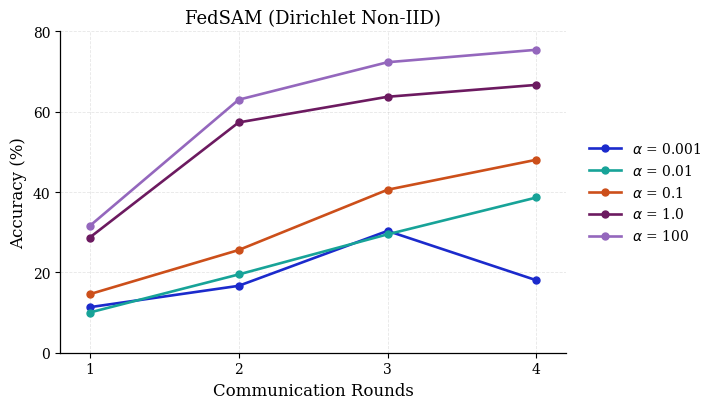

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

# ==================== ICML-STYLE CONFIG ====================
mpl.rcParams.update({
    "text.usetex": False,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 0.8,
    "lines.linewidth": 1.9,
    "lines.markersize": 5,
    "grid.alpha": 0.3,
    "grid.linestyle": "--",
    "grid.linewidth": 0.6,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "figure.figsize": (8.8,4.2),   # exact eval-plot ratio
})
mpl.rcParams["axes.prop_cycle"] = cycler(color=["#1B2ACC", "#17A398", "#CC4F1A", "#6C1A60", "#9467BD"])

def icml_axes(ax):
    """Match the evaluation-plot axis style."""
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(0.9)
    ax.spines["bottom"].set_linewidth(0.9)
    ax.grid(True)
    return ax

# ==================== DATA (Corrected) ====================
fed_sam_logs = {
    0.001: [11.33, 16.65, 30.32, 18.03],
    0.01:  [10.01, 19.48, 29.47, 38.64],
    0.1:   [14.57, 25.56, 40.57, 48.04],
    1.0:   [28.66, 57.32, 63.71, 66.67],
    100:   [31.55, 62.98, 72.31, 75.41],
}

rounds = [1, 2, 3, 4]  # fixed: only 4 recorded rounds

# ==================== PLOTTING ====================
fig, ax = plt.subplots()

for alpha, accs in fed_sam_logs.items():
    ax.plot(
        rounds, accs,
        marker="o",
        linestyle="-",
        label=fr"$\alpha$ = {alpha}"
    )

ax.set_xlabel("Communication Rounds")
ax.set_ylabel("Accuracy (%)")
ax.set_title("FedSAM (Dirichlet Non-IID)", pad=6)
ax = icml_axes(ax)
ax.set_xlim(0.8, 4.2)
ax.set_ylim(0, 80)
ax.set_xticks(rounds)
ax.set_yticks(range(0, 81, 20))

# --- Legend outside (ICML-style) ---
ax.legend(
    frameon=False,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    handlelength=2.3,
)

# --- Layout and Save ---
fig.tight_layout(rect=[0, 0, 0.83, 1])
fig.savefig("fedsam_dirichlet_accuracy.png", dpi=350, bbox_inches="tight")
fig.savefig("fedsam_dirichlet_accuracy.pdf", bbox_inches="tight")
plt.show()


In [ ]:
rhos = [0.001, 0.005, 0.0075]
K = 5

fedsam_results = {}

for rho in rhos:
    clients_sam = [ClientSAM(loader, rho=rho) for loader in client_loaders]
    accs, drifts = run_fedsam_experiment(K, clients_sam, rho, tag="FedSAM_IID")
    fedsam_results[rho] = (accs, drifts)



===== FedSAM | rho=0.001 | K=5 | 4 Rounds =====
Round 01 | Acc: 33.43% | Drift: 33.335
Round 02 | Acc: 61.88% | Drift: 33.783
Round 03 | Acc: 66.93% | Drift: 39.213
Round 04 | Acc: 69.34% | Drift: 41.802

===== FedSAM | rho=0.005 | K=5 | 4 Rounds =====
Round 01 | Acc: 41.71% | Drift: 32.420
Round 02 | Acc: 62.20% | Drift: 32.309
Round 03 | Acc: 66.79% | Drift: 37.512
Round 04 | Acc: 68.33% | Drift: 40.580

===== FedSAM | rho=0.0075 | K=5 | 4 Rounds =====
Round 01 | Acc: 40.69% | Drift: 30.300
Round 02 | Acc: 61.05% | Drift: 30.909
Round 03 | Acc: 66.29% | Drift: 37.043
Round 04 | Acc: 67.83% | Drift: 40.014


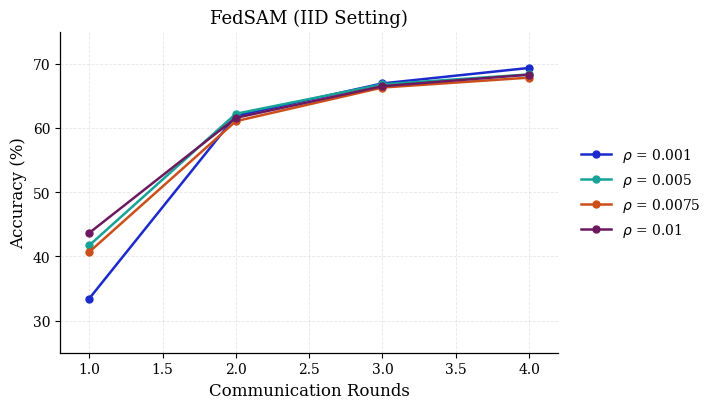

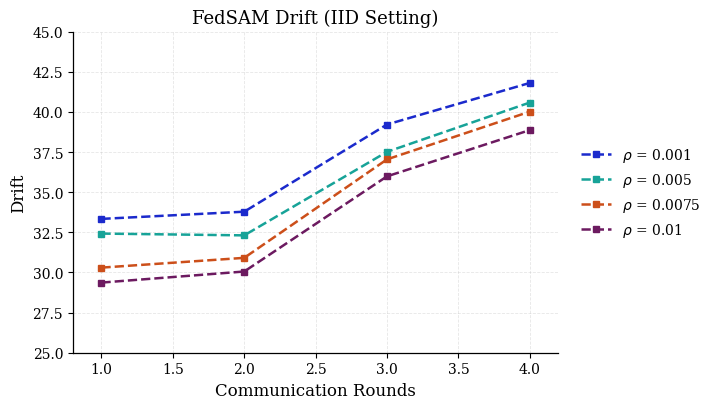

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

# ==================== ICML-STYLE CONFIG ====================
mpl.rcParams.update({
    "text.usetex": False,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "font.family": "serif",
    "font.serif": ["Times New Roman", "CMU Serif", "DejaVu Serif"],
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 0.7,
    "lines.linewidth": 1.8,
    "lines.markersize": 5,
    "grid.alpha": 0.3,
    "grid.linestyle": "--",
    "grid.linewidth": 0.6,
    "figure.figsize": (8.8,4.2),
})
mpl.rcParams["axes.prop_cycle"] = cycler(color=["#1B2ACC", "#17A398", "#CC4F1A", "#6C1A60"])

def icml_axes(ax):
    """Minimal clean paper-style axes."""
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(0.9)
    ax.spines["bottom"].set_linewidth(0.9)
    ax.grid(True)
    return ax

# ==================== FedSAM Results (from logs) ====================
fedsam_acc = {
    0.001: [33.43, 61.88, 66.93, 69.34],
    0.005: [41.71, 62.20, 66.79, 68.33],
    0.0075: [40.69, 61.05, 66.29, 67.83],
    0.01: [43.65, 61.57, 66.50, 68.29],
}
fedsam_drift = {
    0.001: [33.335, 33.783, 39.213, 41.802],
    0.005: [32.420, 32.309, 37.512, 40.580],
    0.0075: [30.300, 30.909, 37.043, 40.014],
    0.01: [29.368, 30.058, 35.985, 38.865],
}
rounds = [1, 2, 3, 4]

# ==================== Plot Accuracy ====================
fig, ax = plt.subplots()
for rho, accs in fedsam_acc.items():
    ax.plot(rounds, accs, marker='o', label=fr"$\rho$ = {rho}")

ax.set_xlabel("Communication Rounds")
ax.set_ylabel("Accuracy (%)")
ax.set_title("FedSAM (IID Setting)", pad=6)
ax = icml_axes(ax)
ax.set_xlim(0.8, 4.2)
ax.set_ylim(25, 75)

ax.legend(frameon=False, loc="center left", bbox_to_anchor=(1.02, 0.5), ncol=1, handlelength=2.2)
fig.tight_layout(rect=[0, 0, 0.83, 1])
fig.savefig("fedsam_rho_accuracy.png", dpi=350, bbox_inches="tight")
fig.savefig("fedsam_rho_accuracy.pdf", bbox_inches="tight")
plt.show()

# ==================== Plot Drift ====================
fig, ax = plt.subplots()
for rho, drifts in fedsam_drift.items():
    ax.plot(rounds, drifts, marker='s', linestyle='--', label=fr"$\rho$ = {rho}")

ax.set_xlabel("Communication Rounds")
ax.set_ylabel("Drift")
ax.set_title("FedSAM Drift (IID Setting)", pad=6)
ax = icml_axes(ax)
ax.set_xlim(0.8, 4.2)
ax.set_ylim(25, 45)

ax.legend(frameon=False, loc="center left", bbox_to_anchor=(1.02, 0.5), ncol=1, handlelength=2.2)
fig.tight_layout(rect=[0, 0, 0.83, 1])
fig.savefig("fedsam_rho_drift.png", dpi=350, bbox_inches="tight")
fig.savefig("fedsam_rho_drift.pdf", bbox_inches="tight")
plt.show()


In [ ]:
alphas = [100]
rho_best = 0.01  # Later we'll confirm from ablation curves
dirichlet_results = {}

for alpha in alphas:
    print(f"\n===== Dirichlet α={alpha} | FedSAM rho={rho_best} =====")
    clients_sam = make_dirichlet_clients(alpha, num_clients)
    clients_sam = [ClientSAM(c.dataloader, rho=rho_best) for c in clients_sam]
    accs, drifts = run_fedsam_experiment(5, clients_sam, rho_best, tag=f"FedSAM_alpha{alpha}")
    dirichlet_results[alpha] = (accs, drifts)



===== Dirichlet α=100 | FedSAM rho=0.01 =====

===== FedSAM | rho=0.01 | K=5 | 4 Rounds =====
Round 01 | Acc: 43.65% | Drift: 29.368
Round 02 | Acc: 61.57% | Drift: 30.058
Round 03 | Acc: 66.50% | Drift: 35.985
Round 04 | Acc: 68.29% | Drift: 38.865


In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({
    "font.family": "serif",
    "text.usetex": True,
    "font.size": 14
})

def plot_accuracy_curves(results_dict, title):
    plt.figure(figsize=(6,4))
    for key, (accs, _) in results_dict.items():
        plt.plot(accs, label=fr"$\rho={key}$", linewidth=2)
    plt.xlabel("Communication Round")
    plt.ylabel("Global Accuracy (\%)")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipython-input-1812024069.py:14: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel("Global Accuracy (\%)")


In [ ]:
plot_accuracy_curves(fedsam_results, "FedSAM Rho Ablation (IID)")
plot_accuracy_curves(dirichlet_results, "FedSAM under Dirichlet Non-IID")
